In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from IPython.core.display import Image, display

from torchsummary import summary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu):
        super(UNetConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size, padding=1)
        self.activation = activation

    def forward(self, x):
        out = self.activation(self.conv(x))
        out = self.activation(self.conv2(out))
        return out

class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, activation=F.relu, space_dropout=False):
        super(UNetUpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, 2, stride=2)
        self.conv = nn.Conv2d(in_size, out_size, kernel_size, padding=1)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size, padding=1)
        self.activation = activation

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], 1)
        out = self.activation(self.conv(out))
        out = self.conv2(out)
        return out

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.activation = F.tanh
        
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
        self.pool4 = nn.MaxPool2d(2)

        self.conv_block3_16 = UNetConvBlock(3, 16)
        self.conv_block16_32 = UNetConvBlock(16, 32)
        self.conv_block32_64 = UNetConvBlock(32, 64)
        self.conv_block64_128 = UNetConvBlock(64, 128)

        self.up_block128_64 = UNetUpBlock(128, 64)
        self.up_block64_32 = UNetUpBlock(64, 32)
        self.up_block32_16 = UNetUpBlock(32, 16)

        self.last = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        block1 = self.conv_block3_16(x)
        pool1 = self.pool1(block1)

        block2 = self.conv_block16_32(pool1)
        pool2 = self.pool2(block2)

        block3 = self.conv_block32_64(pool2)
        pool3 = self.pool3(block3)

        block4 = self.conv_block64_128(pool3)

        up1 = self.activation(self.up_block128_64(block4, block3))

        up2 = self.activation(self.up_block64_32(up1, block2))

        up3 = self.up_block32_16(up2, block1)

        return self.last(up3)

In [3]:
model = UNet()
summary(model, input_size=(3, 64, 64))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
            Conv2d-2           [-1, 16, 64, 64]           2,320
     UNetConvBlock-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
            Conv2d-6           [-1, 32, 32, 32]           9,248
     UNetConvBlock-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
           Conv2d-10           [-1, 64, 16, 16]          36,928
    UNetConvBlock-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
           Conv2d-14            [-1, 12

/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1076: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [4]:
from __future__ import print_function
import zipfile
import os
import pdb
import torch
import h5py
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, transforms, utils

import numpy as np
import torch.nn as nn
import torch

output_height=64
output_width=64

class TransposeDepthInput(object):
    def __call__(self, depth):
        depth = depth.transpose((2, 0, 1))
        depth = torch.from_numpy(depth)
        depth = depth.unsqueeze(0)
        depth = nn.functional.interpolate(depth, size=(output_height, output_width), mode='bilinear', align_corners=False)
        depth = torch.log(depth[0])
        return depth

rgb_data_transforms = transforms.Compose([
    transforms.Resize((output_height, output_width)),    # Different for Input Image & Depth Image
    transforms.ToTensor(),
])

depth_data_transforms = transforms.Compose([
    TransposeDepthInput(),
])

input_for_plot_transforms = transforms.Compose([
    transforms.Resize((output_height, output_width)),    # Different for Input Image & Depth Image
    transforms.ToTensor(),
])

class NYUDataset(Dataset):
    def __init__(self, filename, type, rgb_transform = None, depth_transform = None):
        f = h5py.File(filename, 'r')
        if type == "training":
            self.images = f['images'][0:1024]
            self.depths = f['depths'][0:1024]
        elif type == "validation":
            self.images = f['images'][1024:1248]
            self.depths = f['depths'][1024:1248]
        elif type == "test":
            self.images = f['images'][1248:]
            self.depths = f['depths'][1248:]
        self.rgb_transform = rgb_transform
        self.depth_transform = depth_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.transpose((2, 1, 0))
        image = Image.fromarray(image)
        if self.rgb_transform:
            image = self.rgb_transform(image)
        depth = self.depths[idx]
        depth = np.reshape(depth, (1, depth.shape[0], depth.shape[1]))
        depth = depth.transpose((2, 1, 0))
        if self.depth_transform:
            depth = self.depth_transform(depth)
        sample = {'image': image, 'depth': depth}
        return sample

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import torch
from torchvision import datasets, transforms, utils

batch_size = 1

train_loader = torch.utils.data.DataLoader(NYUDataset( 'nyu_depth_v2_labeled.mat', 
                                                       'training', 
                                                        rgb_transform = rgb_data_transforms, 
                                                        depth_transform = depth_data_transforms), 
                                                        batch_size = batch_size, 
                                                        shuffle = False, num_workers = 0)

val_loader = torch.utils.data.DataLoader(NYUDataset( 'nyu_depth_v2_labeled.mat',
                                                     'validation', 
                                                     rgb_transform = rgb_data_transforms, 
                                                     depth_transform = depth_data_transforms), 
                                                     batch_size = batch_size, 
                                                     shuffle = False, num_workers = 0)

torch.Size([1, 3, 64, 64])
torch.Size([1, 1, 64, 64])


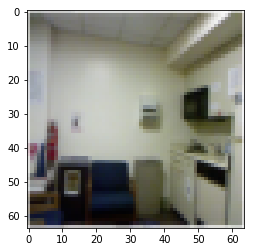

In [6]:
fixed_x = next(iter(train_loader))
rgb = fixed_x['image']
depth = fixed_x['depth']

print(rgb.shape)
print(depth.shape)

plt.imshow(np.transpose(rgb[0].numpy(), (1,2,0)), interpolation="nearest")


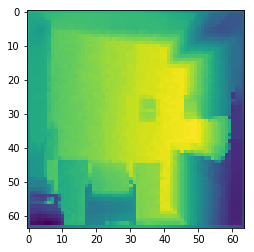

In [7]:
plt.imshow(depth[0][0].numpy(), interpolation="nearest")

In [8]:
def custom_loss_function(output, target):
    # di = torch.log(target) - torch.log(output)
    di = target - output
    n = (output_height * output_width)
    di2 = torch.pow(di, 2)
    fisrt_term = torch.sum(di2,(1,2,3))/n
    second_term = 0.5*torch.pow(torch.sum(di,(1,2,3)), 2)/ (n**2)
    loss = fisrt_term - second_term
    return loss.sum()

In [9]:
%%time

epochs = 3000
for epoch in range(epochs):
    for idx, image in enumerate(train_loader):
        x = image['image']
        y = image['depth']

        y_hat = model(x)
        loss = custom_loss_function(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item())
        print(to_print)
        if idx == 0: break

Epoch[1/3000] Loss: 0.627
Epoch[2/3000] Loss: 0.070
Epoch[3/3000] Loss: 14.458
Epoch[4/3000] Loss: 0.309
Epoch[5/3000] Loss: 0.237
Epoch[6/3000] Loss: 0.186
Epoch[7/3000] Loss: 0.395
Epoch[8/3000] Loss: 0.127
Epoch[9/3000] Loss: 0.062
Epoch[10/3000] Loss: 0.208
Epoch[11/3000] Loss: 0.283
Epoch[12/3000] Loss: 0.207
Epoch[13/3000] Loss: 0.103
Epoch[14/3000] Loss: 0.085
Epoch[15/3000] Loss: 0.131
Epoch[16/3000] Loss: 0.141
Epoch[17/3000] Loss: 0.090
Epoch[18/3000] Loss: 0.056
Epoch[19/3000] Loss: 0.062
Epoch[20/3000] Loss: 0.102
Epoch[21/3000] Loss: 0.074
Epoch[22/3000] Loss: 0.035
Epoch[23/3000] Loss: 0.042
Epoch[24/3000] Loss: 0.047
Epoch[25/3000] Loss: 0.058
Epoch[26/3000] Loss: 0.060
Epoch[27/3000] Loss: 0.037
Epoch[28/3000] Loss: 0.033
Epoch[29/3000] Loss: 0.032
Epoch[30/3000] Loss: 0.032
Epoch[31/3000] Loss: 0.042
Epoch[32/3000] Loss: 0.038
Epoch[33/3000] Loss: 0.036
Epoch[34/3000] Loss: 0.033
Epoch[35/3000] Loss: 0.026
Epoch[36/3000] Loss: 0.028
Epoch[37/3000] Loss: 0.027
Epoch[38/

Epoch[298/3000] Loss: 0.010
Epoch[299/3000] Loss: 0.010
Epoch[300/3000] Loss: 0.010
Epoch[301/3000] Loss: 0.010
Epoch[302/3000] Loss: 0.010
Epoch[303/3000] Loss: 0.010
Epoch[304/3000] Loss: 0.010
Epoch[305/3000] Loss: 0.010
Epoch[306/3000] Loss: 0.010
Epoch[307/3000] Loss: 0.010
Epoch[308/3000] Loss: 0.010
Epoch[309/3000] Loss: 0.010
Epoch[310/3000] Loss: 0.010
Epoch[311/3000] Loss: 0.010
Epoch[312/3000] Loss: 0.010
Epoch[313/3000] Loss: 0.010
Epoch[314/3000] Loss: 0.010
Epoch[315/3000] Loss: 0.010
Epoch[316/3000] Loss: 0.010
Epoch[317/3000] Loss: 0.010
Epoch[318/3000] Loss: 0.010
Epoch[319/3000] Loss: 0.011
Epoch[320/3000] Loss: 0.011
Epoch[321/3000] Loss: 0.011
Epoch[322/3000] Loss: 0.011
Epoch[323/3000] Loss: 0.011
Epoch[324/3000] Loss: 0.010
Epoch[325/3000] Loss: 0.010
Epoch[326/3000] Loss: 0.010
Epoch[327/3000] Loss: 0.010
Epoch[328/3000] Loss: 0.010
Epoch[329/3000] Loss: 0.010
Epoch[330/3000] Loss: 0.010
Epoch[331/3000] Loss: 0.011
Epoch[332/3000] Loss: 0.011
Epoch[333/3000] Loss

Epoch[594/3000] Loss: 0.008
Epoch[595/3000] Loss: 0.008
Epoch[596/3000] Loss: 0.008
Epoch[597/3000] Loss: 0.007
Epoch[598/3000] Loss: 0.007
Epoch[599/3000] Loss: 0.007
Epoch[600/3000] Loss: 0.008
Epoch[601/3000] Loss: 0.008
Epoch[602/3000] Loss: 0.008
Epoch[603/3000] Loss: 0.008
Epoch[604/3000] Loss: 0.007
Epoch[605/3000] Loss: 0.007
Epoch[606/3000] Loss: 0.007
Epoch[607/3000] Loss: 0.007
Epoch[608/3000] Loss: 0.007
Epoch[609/3000] Loss: 0.007
Epoch[610/3000] Loss: 0.007
Epoch[611/3000] Loss: 0.007
Epoch[612/3000] Loss: 0.007
Epoch[613/3000] Loss: 0.007
Epoch[614/3000] Loss: 0.007
Epoch[615/3000] Loss: 0.007
Epoch[616/3000] Loss: 0.007
Epoch[617/3000] Loss: 0.007
Epoch[618/3000] Loss: 0.007
Epoch[619/3000] Loss: 0.007
Epoch[620/3000] Loss: 0.007
Epoch[621/3000] Loss: 0.007
Epoch[622/3000] Loss: 0.007
Epoch[623/3000] Loss: 0.007
Epoch[624/3000] Loss: 0.007
Epoch[625/3000] Loss: 0.007
Epoch[626/3000] Loss: 0.007
Epoch[627/3000] Loss: 0.007
Epoch[628/3000] Loss: 0.007
Epoch[629/3000] Loss

Epoch[889/3000] Loss: 0.008
Epoch[890/3000] Loss: 0.008
Epoch[891/3000] Loss: 0.007
Epoch[892/3000] Loss: 0.007
Epoch[893/3000] Loss: 0.007
Epoch[894/3000] Loss: 0.007
Epoch[895/3000] Loss: 0.007
Epoch[896/3000] Loss: 0.006
Epoch[897/3000] Loss: 0.006
Epoch[898/3000] Loss: 0.007
Epoch[899/3000] Loss: 0.007
Epoch[900/3000] Loss: 0.006
Epoch[901/3000] Loss: 0.006
Epoch[902/3000] Loss: 0.006
Epoch[903/3000] Loss: 0.006
Epoch[904/3000] Loss: 0.006
Epoch[905/3000] Loss: 0.006
Epoch[906/3000] Loss: 0.006
Epoch[907/3000] Loss: 0.006
Epoch[908/3000] Loss: 0.006
Epoch[909/3000] Loss: 0.006
Epoch[910/3000] Loss: 0.006
Epoch[911/3000] Loss: 0.006
Epoch[912/3000] Loss: 0.006
Epoch[913/3000] Loss: 0.006
Epoch[914/3000] Loss: 0.006
Epoch[915/3000] Loss: 0.006
Epoch[916/3000] Loss: 0.006
Epoch[917/3000] Loss: 0.006
Epoch[918/3000] Loss: 0.006
Epoch[919/3000] Loss: 0.006
Epoch[920/3000] Loss: 0.006
Epoch[921/3000] Loss: 0.006
Epoch[922/3000] Loss: 0.006
Epoch[923/3000] Loss: 0.006
Epoch[924/3000] Loss

Epoch[1176/3000] Loss: 0.005
Epoch[1177/3000] Loss: 0.006
Epoch[1178/3000] Loss: 0.006
Epoch[1179/3000] Loss: 0.006
Epoch[1180/3000] Loss: 0.006
Epoch[1181/3000] Loss: 0.006
Epoch[1182/3000] Loss: 0.006
Epoch[1183/3000] Loss: 0.005
Epoch[1184/3000] Loss: 0.005
Epoch[1185/3000] Loss: 0.005
Epoch[1186/3000] Loss: 0.005
Epoch[1187/3000] Loss: 0.005
Epoch[1188/3000] Loss: 0.005
Epoch[1189/3000] Loss: 0.005
Epoch[1190/3000] Loss: 0.005
Epoch[1191/3000] Loss: 0.005
Epoch[1192/3000] Loss: 0.005
Epoch[1193/3000] Loss: 0.005
Epoch[1194/3000] Loss: 0.006
Epoch[1195/3000] Loss: 0.006
Epoch[1196/3000] Loss: 0.006
Epoch[1197/3000] Loss: 0.006
Epoch[1198/3000] Loss: 0.007
Epoch[1199/3000] Loss: 0.007
Epoch[1200/3000] Loss: 0.006
Epoch[1201/3000] Loss: 0.006
Epoch[1202/3000] Loss: 0.005
Epoch[1203/3000] Loss: 0.006
Epoch[1204/3000] Loss: 0.006
Epoch[1205/3000] Loss: 0.006
Epoch[1206/3000] Loss: 0.006
Epoch[1207/3000] Loss: 0.006
Epoch[1208/3000] Loss: 0.005
Epoch[1209/3000] Loss: 0.005
Epoch[1210/300

Epoch[1461/3000] Loss: 0.006
Epoch[1462/3000] Loss: 0.006
Epoch[1463/3000] Loss: 0.005
Epoch[1464/3000] Loss: 0.005
Epoch[1465/3000] Loss: 0.005
Epoch[1466/3000] Loss: 0.005
Epoch[1467/3000] Loss: 0.006
Epoch[1468/3000] Loss: 0.005
Epoch[1469/3000] Loss: 0.005
Epoch[1470/3000] Loss: 0.005
Epoch[1471/3000] Loss: 0.005
Epoch[1472/3000] Loss: 0.005
Epoch[1473/3000] Loss: 0.005
Epoch[1474/3000] Loss: 0.005
Epoch[1475/3000] Loss: 0.005
Epoch[1476/3000] Loss: 0.005
Epoch[1477/3000] Loss: 0.005
Epoch[1478/3000] Loss: 0.005
Epoch[1479/3000] Loss: 0.005
Epoch[1480/3000] Loss: 0.005
Epoch[1481/3000] Loss: 0.005
Epoch[1482/3000] Loss: 0.005
Epoch[1483/3000] Loss: 0.005
Epoch[1484/3000] Loss: 0.005
Epoch[1485/3000] Loss: 0.005
Epoch[1486/3000] Loss: 0.005
Epoch[1487/3000] Loss: 0.005
Epoch[1488/3000] Loss: 0.005
Epoch[1489/3000] Loss: 0.005
Epoch[1490/3000] Loss: 0.005
Epoch[1491/3000] Loss: 0.005
Epoch[1492/3000] Loss: 0.005
Epoch[1493/3000] Loss: 0.006
Epoch[1494/3000] Loss: 0.006
Epoch[1495/300

Epoch[1745/3000] Loss: 0.005
Epoch[1746/3000] Loss: 0.005
Epoch[1747/3000] Loss: 0.005
Epoch[1748/3000] Loss: 0.005
Epoch[1749/3000] Loss: 0.005
Epoch[1750/3000] Loss: 0.005
Epoch[1751/3000] Loss: 0.004
Epoch[1752/3000] Loss: 0.004
Epoch[1753/3000] Loss: 0.005
Epoch[1754/3000] Loss: 0.005
Epoch[1755/3000] Loss: 0.005
Epoch[1756/3000] Loss: 0.006
Epoch[1757/3000] Loss: 0.005
Epoch[1758/3000] Loss: 0.005
Epoch[1759/3000] Loss: 0.005
Epoch[1760/3000] Loss: 0.004
Epoch[1761/3000] Loss: 0.005
Epoch[1762/3000] Loss: 0.005
Epoch[1763/3000] Loss: 0.005
Epoch[1764/3000] Loss: 0.005
Epoch[1765/3000] Loss: 0.005
Epoch[1766/3000] Loss: 0.005
Epoch[1767/3000] Loss: 0.004
Epoch[1768/3000] Loss: 0.005
Epoch[1769/3000] Loss: 0.005
Epoch[1770/3000] Loss: 0.005
Epoch[1771/3000] Loss: 0.005
Epoch[1772/3000] Loss: 0.006
Epoch[1773/3000] Loss: 0.005
Epoch[1774/3000] Loss: 0.005
Epoch[1775/3000] Loss: 0.005
Epoch[1776/3000] Loss: 0.005
Epoch[1777/3000] Loss: 0.005
Epoch[1778/3000] Loss: 0.006
Epoch[1779/300

Epoch[2028/3000] Loss: 0.005
Epoch[2029/3000] Loss: 0.005
Epoch[2030/3000] Loss: 0.005
Epoch[2031/3000] Loss: 0.004
Epoch[2032/3000] Loss: 0.004
Epoch[2033/3000] Loss: 0.004
Epoch[2034/3000] Loss: 0.004
Epoch[2035/3000] Loss: 0.004
Epoch[2036/3000] Loss: 0.005
Epoch[2037/3000] Loss: 0.005
Epoch[2038/3000] Loss: 0.004
Epoch[2039/3000] Loss: 0.004
Epoch[2040/3000] Loss: 0.004
Epoch[2041/3000] Loss: 0.004
Epoch[2042/3000] Loss: 0.004
Epoch[2043/3000] Loss: 0.004
Epoch[2044/3000] Loss: 0.004
Epoch[2045/3000] Loss: 0.004
Epoch[2046/3000] Loss: 0.004
Epoch[2047/3000] Loss: 0.005
Epoch[2048/3000] Loss: 0.005
Epoch[2049/3000] Loss: 0.005
Epoch[2050/3000] Loss: 0.005
Epoch[2051/3000] Loss: 0.005
Epoch[2052/3000] Loss: 0.004
Epoch[2053/3000] Loss: 0.004
Epoch[2054/3000] Loss: 0.004
Epoch[2055/3000] Loss: 0.004
Epoch[2056/3000] Loss: 0.004
Epoch[2057/3000] Loss: 0.005
Epoch[2058/3000] Loss: 0.005
Epoch[2059/3000] Loss: 0.005
Epoch[2060/3000] Loss: 0.005
Epoch[2061/3000] Loss: 0.004
Epoch[2062/300

Epoch[2311/3000] Loss: 0.003
Epoch[2312/3000] Loss: 0.003
Epoch[2313/3000] Loss: 0.004
Epoch[2314/3000] Loss: 0.004
Epoch[2315/3000] Loss: 0.004
Epoch[2316/3000] Loss: 0.004
Epoch[2317/3000] Loss: 0.004
Epoch[2318/3000] Loss: 0.004
Epoch[2319/3000] Loss: 0.004
Epoch[2320/3000] Loss: 0.004
Epoch[2321/3000] Loss: 0.004
Epoch[2322/3000] Loss: 0.003
Epoch[2323/3000] Loss: 0.003
Epoch[2324/3000] Loss: 0.004
Epoch[2325/3000] Loss: 0.004
Epoch[2326/3000] Loss: 0.004
Epoch[2327/3000] Loss: 0.004
Epoch[2328/3000] Loss: 0.004
Epoch[2329/3000] Loss: 0.004
Epoch[2330/3000] Loss: 0.004
Epoch[2331/3000] Loss: 0.004
Epoch[2332/3000] Loss: 0.004
Epoch[2333/3000] Loss: 0.004
Epoch[2334/3000] Loss: 0.004
Epoch[2335/3000] Loss: 0.003
Epoch[2336/3000] Loss: 0.003
Epoch[2337/3000] Loss: 0.003
Epoch[2338/3000] Loss: 0.004
Epoch[2339/3000] Loss: 0.004
Epoch[2340/3000] Loss: 0.004
Epoch[2341/3000] Loss: 0.004
Epoch[2342/3000] Loss: 0.004
Epoch[2343/3000] Loss: 0.004
Epoch[2344/3000] Loss: 0.005
Epoch[2345/300

Epoch[2594/3000] Loss: 0.003
Epoch[2595/3000] Loss: 0.003
Epoch[2596/3000] Loss: 0.003
Epoch[2597/3000] Loss: 0.004
Epoch[2598/3000] Loss: 0.004
Epoch[2599/3000] Loss: 0.004
Epoch[2600/3000] Loss: 0.004
Epoch[2601/3000] Loss: 0.004
Epoch[2602/3000] Loss: 0.004
Epoch[2603/3000] Loss: 0.003
Epoch[2604/3000] Loss: 0.003
Epoch[2605/3000] Loss: 0.003
Epoch[2606/3000] Loss: 0.003
Epoch[2607/3000] Loss: 0.003
Epoch[2608/3000] Loss: 0.004
Epoch[2609/3000] Loss: 0.004
Epoch[2610/3000] Loss: 0.004
Epoch[2611/3000] Loss: 0.004
Epoch[2612/3000] Loss: 0.004
Epoch[2613/3000] Loss: 0.004
Epoch[2614/3000] Loss: 0.003
Epoch[2615/3000] Loss: 0.003
Epoch[2616/3000] Loss: 0.003
Epoch[2617/3000] Loss: 0.003
Epoch[2618/3000] Loss: 0.003
Epoch[2619/3000] Loss: 0.003
Epoch[2620/3000] Loss: 0.003
Epoch[2621/3000] Loss: 0.004
Epoch[2622/3000] Loss: 0.004
Epoch[2623/3000] Loss: 0.004
Epoch[2624/3000] Loss: 0.004
Epoch[2625/3000] Loss: 0.004
Epoch[2626/3000] Loss: 0.004
Epoch[2627/3000] Loss: 0.004
Epoch[2628/300

Epoch[2877/3000] Loss: 0.004
Epoch[2878/3000] Loss: 0.003
Epoch[2879/3000] Loss: 0.003
Epoch[2880/3000] Loss: 0.003
Epoch[2881/3000] Loss: 0.004
Epoch[2882/3000] Loss: 0.004
Epoch[2883/3000] Loss: 0.004
Epoch[2884/3000] Loss: 0.004
Epoch[2885/3000] Loss: 0.003
Epoch[2886/3000] Loss: 0.003
Epoch[2887/3000] Loss: 0.003
Epoch[2888/3000] Loss: 0.003
Epoch[2889/3000] Loss: 0.003
Epoch[2890/3000] Loss: 0.003
Epoch[2891/3000] Loss: 0.003
Epoch[2892/3000] Loss: 0.003
Epoch[2893/3000] Loss: 0.003
Epoch[2894/3000] Loss: 0.003
Epoch[2895/3000] Loss: 0.003
Epoch[2896/3000] Loss: 0.003
Epoch[2897/3000] Loss: 0.003
Epoch[2898/3000] Loss: 0.003
Epoch[2899/3000] Loss: 0.003
Epoch[2900/3000] Loss: 0.003
Epoch[2901/3000] Loss: 0.003
Epoch[2902/3000] Loss: 0.003
Epoch[2903/3000] Loss: 0.003
Epoch[2904/3000] Loss: 0.003
Epoch[2905/3000] Loss: 0.003
Epoch[2906/3000] Loss: 0.003
Epoch[2907/3000] Loss: 0.003
Epoch[2908/3000] Loss: 0.003
Epoch[2909/3000] Loss: 0.003
Epoch[2910/3000] Loss: 0.003
Epoch[2911/300

torch.Size([1, 1, 64, 64])


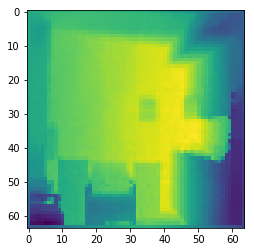

In [12]:
import matplotlib.pyplot as plt
import numpy as np

y_hat = model(x)

print(y_hat.shape)
plt.imshow(y_hat[0][0].detach().numpy(), interpolation="nearest")
# save_image(y_hat.cpu(), 'sample_image.png')
# display(Image('sample_image.png', width=300, unconfined=True))